#### 1. 参考课堂案例，使用指定的数据集，编写代码实现ner模型训练和推流。https://huggingface.co/datasets/doushabao4766/msra_ner_k_V3
#### 2. 完成预测结果的实体抽取。输入：“双方确定了今后发展中美关系的指导方针。”输出：[{"entity":"ORG","content":"中"},{"entity":"ORG""content":"美"}]


In [3]:
from transformers import AutoModelForTokenClassification, AutoTokenizer,DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import torch
import evaluate  
import seqeval  
from datasets import load_dataset


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
#加载数据集
ds = load_dataset("doushabao4766/msra_ner_k_V3")


In [ ]:
ds['train']
for row in ds['train']:
    print(row)
    print(row['tokens'])
    print(row['ner_tags'])
    break
    

## 实体映射数据集词典准备

In [ ]:
tag_id = set()
for items in ds['train']:
    tag_id.update(items['ner_tags'])

tag_id

In [ ]:
# entity_index
entites = ['O'] + list({'PER', 'LOC', 'ORG'})
tags = ['O']
for entity in entites[1:]:
    tags.append('B-' + entity.upper())
    tags.append('I-' + entity.upper())

entity_index = {entity:i for i, entity in enumerate(entites)}

entity_index

tags

In [ ]:
tokenizer =AutoTokenizer.from_pretrained('google-bert/bert-base-chinese')

# 原始文本转换模型需要token_idx,生成和token_idx对齐label
def data_input_proc(item):
    # 输入文本转换模型输入token索引
    input_data = tokenizer(item['tokens'], 
                           truncation=True, 
                           add_special_tokens=False, 
                           max_length=512, 
                           is_split_into_words=True,
                           return_offsets_mapping=True)

    lables = [lbl[:512] for lbl in item['ner_tags']]
    # 修正后label添加到input_data
    input_data['labels'] = lables
    return input_data
    

ds1 = ds.map(data_input_proc, batched=True)  # batched 每次传入自定义方法样本数量多个

In [ ]:
ds1.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

for item in ds1['train']:
    print(item)
    break

## 模型训练
### TrainingArguments

In [ ]:
# model
id2lbl = {i:tag for i, tag in enumerate(tags)}
lbl2id = {tag:i for i, tag in enumerate(tags)}

model = AutoModelForTokenClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                        num_labels=len(tags),
                                                        id2label=id2lbl,
                                                        label2id=lbl2id)
model

In [ ]:
args = TrainingArguments(
    output_dir="msra_ner_train",  # 模型训练工作目录（tensorboard，临时模型存盘文件，日志）
    num_train_epochs = 3,    # 训练 epoch
    # save_safetensors=False,  # 设置False保存文件可以通过torch.load加载
    per_device_train_batch_size=32,  # 训练批次
    per_device_eval_batch_size=32,
    report_to='tensorboard',  # 训练输出记录
    eval_strategy="epoch",
)

## Trainer

In [ ]:
# metric 方法
import numpy as np
def compute_metric(result):
    # result 是一个tuple (predicts, labels)
    
    # 获取评估对象
    seqeval = evaluate.load('seqeval')
    predicts,labels = result
    predicts = np.argmax(predicts, axis=2)
    
    # 准备评估数据
    predicts = [[tags[p] for p,l in zip(ps,ls) if l != -100]
                 for ps,ls in zip(predicts,labels)]
    labels = [[tags[l] for p,l in zip(ps,ls) if l != -100]
                 for ps,ls in zip(predicts,labels)]
    results = seqeval.compute(predictions=predicts, references=labels)

    return results


In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)


In [ ]:

trainer = Trainer(
    model,
    args,
    train_dataset=ds1['train'],
    eval_dataset=ds1['test'],
    data_collator=data_collator,
    compute_metrics=compute_metric
)

In [ ]:
# 模型训练
trainer.train()

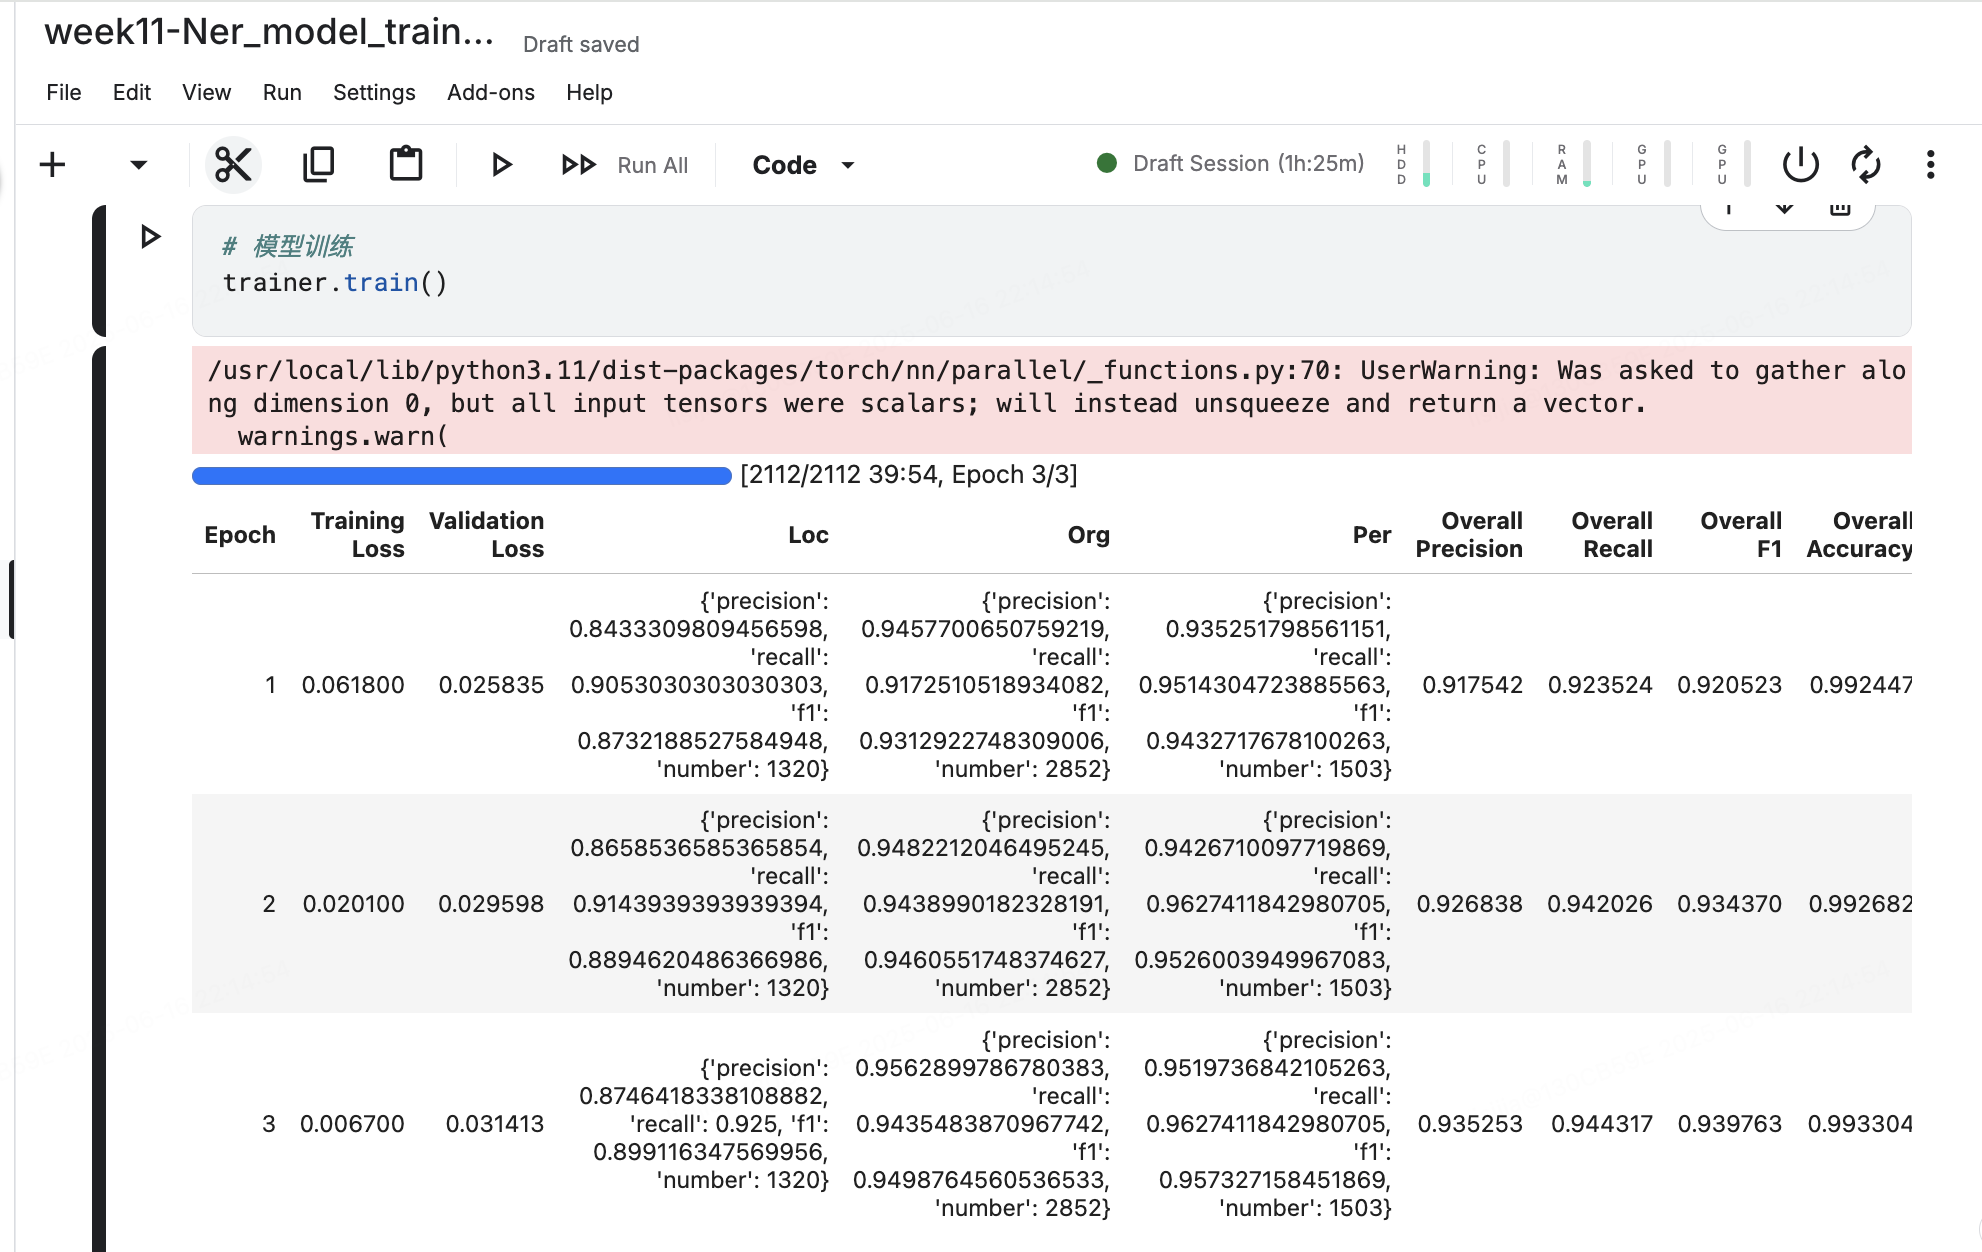

## 模型推理

In [ ]:
from transformers import pipeline

In [ ]:
pipeline = pipeline('token-classification', 'msra_ner_train/checkpoint-2112')
pipeline('双方确定了今后发展中美关系的指导方针')

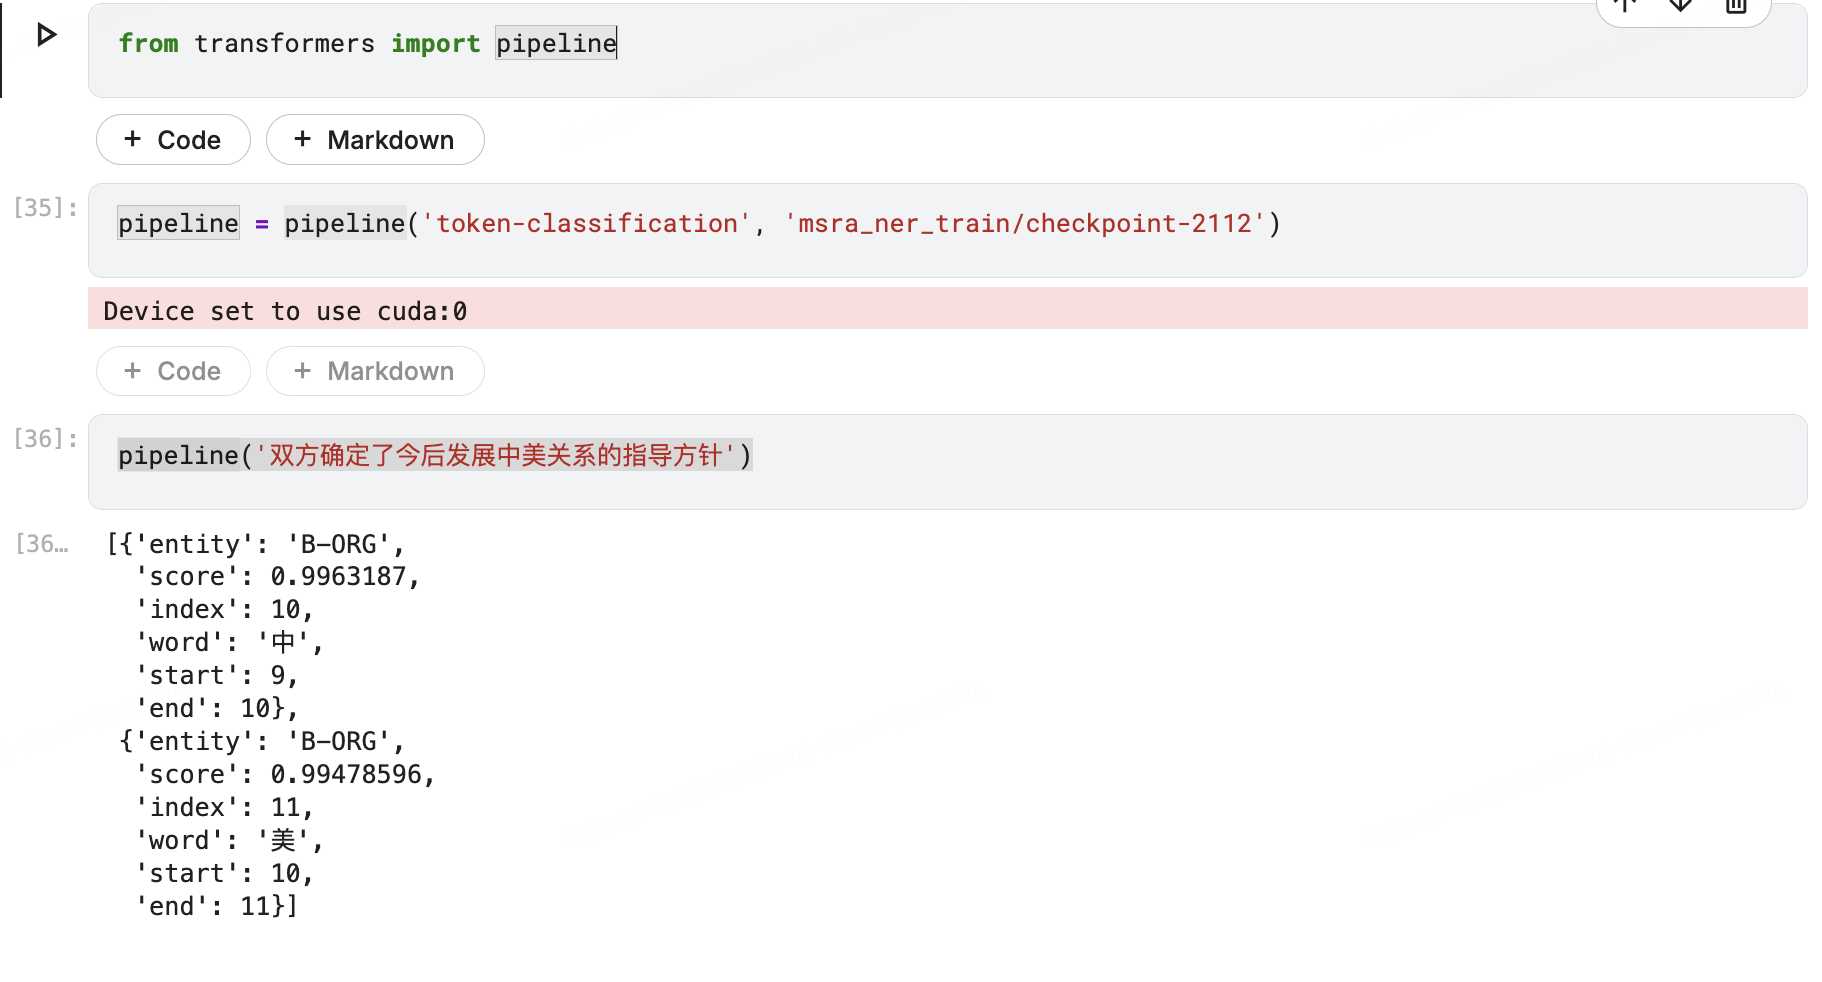